# Using transport-cba to evaluate the potential of a city bypass

Created: 2020-02-18
Last edit: 2023-07-30

In this tutorial we demonstrate the power in determining 
the economic efficiency of several variants of a bypass of a medium-sized city.

Assume that we are supplied with project inputs that position this bypass 
only slightly above the threshold economic efficiency (BCR = 1.0).
We would would like to explora ways to increase the positive impact 
of this investment.

In [1]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from transport_cba import RoadCBA
from transport_cba.sample_projects import load_sample_bypass

In [3]:
b = load_sample_bypass()

The bypass is one road section 3.9 km long with 100 m of bridges. The original road has in total 4.9 km.

In [4]:
b["RP"]

,name,variant_0,variant_1,length,length_bridges,length_tunnels,category,lanes,environment,width,layout,toll_sections
id_section,,,,,,,,,,,,
0,entrance,1,1,0.5,0.0,0,standard,2,extravilan,9.5,wide,1
1,city,1,1,4.0,0.0,0,standard,2,intravilan,9.5,narrow,1
2,exit,1,1,0.4,0.0,0,standard,2,extravilan,9.5,wide,1
3,bypass,0,1,3.9,0.1,0,standard,2,extravilan,11.5,wide,1


The CAPEX is as follows:

In [5]:
b["C_fin"]

,,2020,2021,2022
item,category,,,
planning and design,preparation,150000,150000,150000
land,preparation,300000,300000,300000
site preparation,construction,0,0,0
earthworks,construction,0,0,0
pavements asphalt,construction,14000000,14000000,14000000
pavements concrete,construction,0,0,0
bridges,construction,1500000,1500000,1500000
tunnels,construction,0,0,0
buildings,construction,0,0,0


The economic analysis of the default inputs is:

In [6]:
rcba = RoadCBA(2020, 2020, "svk")
rcba.load_parameters()
rcba.read_project_inputs(*b.values())
rcba.economic_analysis()

Done. Time: 1.06 s.


In [7]:
rcba.print_economic_indicators()

ENPV: 3.34 M EUR
ERR : 5.62 %
BCR : 1.08


In [8]:
rcba.EBCR

1.0757620136184416

The BCR of the bypass is only slightly above 1.0, 
which might not be sufficient to justify the investment.

Hence, we look into ways to increase the BCR.

## 1. Variation in the bypass length

Assume there is freedom in choosing the exact route of the new road section.
Thus, it is possible to find a length cutoff for which BCR would cross 1.5.

Assume that the shortest possible distance is 3 km.

In [9]:
b = load_sample_bypass()

In [10]:
ls = np.arange(3, 5, 0.2)
BCRs = []

In [11]:
%%time

for l in ls:
    b["RP"].loc[3, "length"] = l
    
    rcba = RoadCBA(2020, 2020, "svk")
    rcba.load_parameters()
    rcba.read_project_inputs(*b.values())
    rcba.economic_analysis()
    
    BCRs.append(rcba.EBCR)

Done. Time: 1.04 s.
Done. Time: 1.06 s.
Done. Time: 1.05 s.
Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.05 s.
Done. Time: 1.05 s.
Done. Time: 1.04 s.
Done. Time: 1.05 s.
CPU times: user 10.8 s, sys: 131 ms, total: 10.9 s
Wall time: 11 s


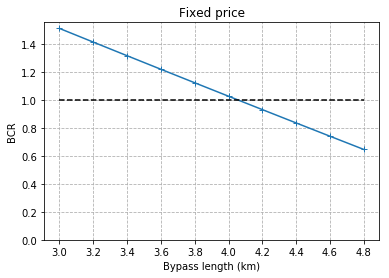

In [12]:
plt.plot(ls, BCRs, "+-")
plt.plot(ls, np.ones_like(ls), "k--")
plt.xlabel("Bypass length (km)")
plt.ylabel("BCR")
plt.ylim(bottom=0)
plt.xticks(ls)
plt.title("Fixed price")
plt.grid(linestyle="--")

Hence, only the 3 km long bypass yields BCR above 1.5.
However, this assumes that the price does not change, which is unrealistic.

## 2. Variation in length and investment cost

As a next step, we vary both the length of the bypass 
and the price such that it remains proportional to the length.

In [13]:
ls = np.arange(3, 5, 0.2)

In [14]:
BCRs = []

b = load_sample_bypass()
l_0 = 3.9
capex_0 = b["C_fin"]

for l in ls:
    b["RP"].loc[3, "length"] = l
    b["C_fin"] = capex_0 * l / l_0
    
    rcba = RoadCBA(2020, 2020, "svk")
    rcba.load_parameters()
    rcba.read_project_inputs(*b.values())
    rcba.economic_analysis()
    BCRs.append(rcba.EBCR)

Done. Time: 1.03 s.
Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.04 s.


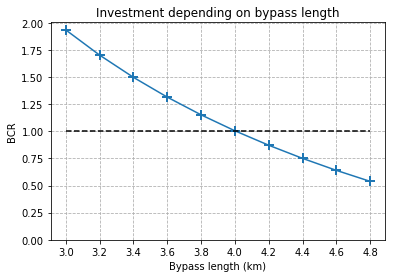

In [15]:
plt.plot(ls, BCRs, "+-", ms=10, mew=2)
plt.plot(ls, np.ones_like(ls), "k--")
plt.xlabel("Bypass length (km)")
plt.ylabel("BCR")
plt.xticks(ls)
plt.ylim(bottom=0)
plt.title("Investment depending on bypass length")
plt.grid(linestyle="--")

Hence, length of 3.4 km or less is enough to get over (or very close to) BCR = 1.5.

This should be made more accurate, as the length of the bridge does not change
and so the cost of building the bridge remains fixed. But it is a reasonable
first estimate.

## 3. Sensitivity to increase in traffic

There can be a systematic error in how the traffic was measured 
or modelled. It is thus vital to explore sensitivity of the BCR
of the project with respect to its variations.

There are infinitely many ways to vary the traffic, all of which 
can be explored in a reproducible manner by modifying the dataframes
with intensities.

Here we simply vary the intensities adding between 100 and 1000 
cars and trucks (HGV), assuming all of these decide to use the
bypass once finished.

NB: There is also a possibility that the construction of this bypass 
will attract long-distance traffic currently passing through 
another region.
Generally it is not enough to just add these transit intensities 
to the existing local ones and compute the saved time or distance,
because variant 0 for this traffic component is different, 
ie a road (or whole corridor) outside of this project.

In [16]:
yr_op = b["C_fin"].columns[-1] + 1 # first year of operation
id_op = list(b["I1"].columns).index(yr_op) # index of the first year of operation

secs_old = [0, 1, 2]

In [17]:
b = load_sample_bypass()

dIs = np.linspace(-600, 1000, 9)

In [18]:
BCRs = []

for dI in dIs:
    I0 = b["I0"].copy()
    I0.loc[idx[:, ["hgv", "car"]], I0.columns] += dI
    
    I1 = b["I1"].copy()
    I1.loc[idx[3, "car"], I1.columns[id_op:]] += dI
    I1.loc[idx[3, "hgv"], I1.columns[id_op:]] += dI
    
    I1.loc[idx[secs_old, "car"], I1.columns[:id_op]] += dI
    I1.loc[idx[secs_old, "hgv"], I1.columns[:id_op]] += dI
    
    rcba = RoadCBA(2020, 2020, "svk")
    rcba.load_parameters()
    rcba.read_project_inputs(b["RP"], b["C_fin"], I0, I1, b["V0"], b["V1"])
    rcba.economic_analysis()
    BCRs.append(rcba.EBCR)

Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.04 s.
Done. Time: 1.03 s.
Done. Time: 1.04 s.
Done. Time: 1.03 s.
Done. Time: 1.03 s.
Done. Time: 1.04 s.


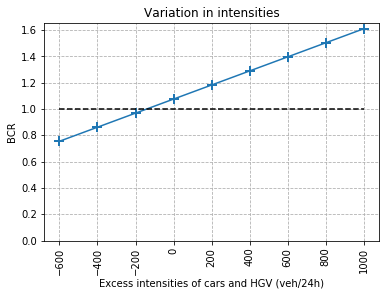

In [19]:
plt.plot(dIs, BCRs, "+-", ms=10, mew=2)
plt.plot(dIs, np.ones_like(dIs), "k--")
plt.xlabel("Excess intensities of cars and HGV (veh/24h)")
plt.ylabel("BCR")
plt.xticks(dIs, rotation=90)
plt.ylim(bottom=0)
plt.title("Variation in intensities")
plt.grid(linestyle="--")

The increase in BCR is, somehow unsurprisingly, linear.

## 4. Construction periods

Finally, we investigate the impact of a range of construction periods on BCR.
As the overall economic lifetime is fixed (usually) at 30 years, 
construction period has a considerable impact.

In [20]:
b = load_sample_bypass()

In [21]:
yr_i = b["C_fin"].columns[0]
N_yrs_bld = list(range(1, 6))

In [23]:
# fill values before the official start

yr = yr_op - 1
while yr >= yr_i:
    growth_fac = (b["I1"][yr+2] / b["I1"][yr+1]).fillna(1)
    b["I1"][yr] = (b["I1"][yr+1] / growth_fac).astype(int)
    yr -= 1 

In [22]:
capex = b["C_fin"].copy()

In [25]:
BCRs = []

for N_yr_bld in N_yrs_bld:
    yrs_bld = np.arange(yr_i, yr_i + N_yr_bld)
    
    # restructure CAPEX
    capex = pd.DataFrame(pd.concat([b["C_fin"].sum(1)] * N_yr_bld, 1) / N_yr_bld)
    capex.columns = yrs_bld
    
    # recompute intensities
    I1 = b["I1"].copy()
    I1[yrs_bld] = I0[yrs_bld]
    I1 = I1.fillna(0)
    
    rcba = RoadCBA(2020, 2020, "svk")
    rcba.load_parameters()
    rcba.read_project_inputs(b["RP"], capex, b["I0"], I1, b["V0"], b["V1"])
    rcba.economic_analysis()
    BCRs.append(rcba.EBCR)

Done. Time: 1.12 s.
Done. Time: 1.09 s.
Done. Time: 1.09 s.
Done. Time: 1.09 s.
Done. Time: 1.09 s.


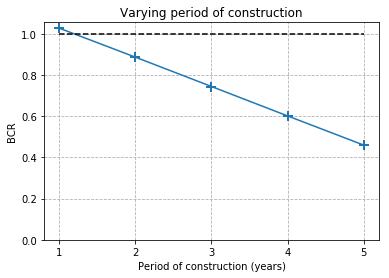

In [26]:
plt.plot(N_yrs_bld, BCRs, "+-", ms=10, mew=2)
plt.plot(N_yrs_bld, np.ones_like(N_yrs_bld), "k--")
plt.xlabel("Period of construction (years)")
plt.ylabel("BCR")
plt.xticks(N_yrs_bld)
plt.ylim(bottom=0)
plt.title("Varying period of construction")
plt.grid(linestyle="--")